### Устанавливаем библиотеки 




Задача № 3 (для 2 курса)
 
Название: Автоматизация обработки машиночитаемых документов.
 
Описание: Вам будет выдан набор данных документов из системы документооборота небольшой вымышленной компании. На основе этого набора данных вам нужно построить граф знаний о компании, который включает:

● 	Организационную структуру (список подразделений). Есть

● 	Список сотрудников 

●  и их должностей. 

● 	Должностные обязанности и полномочия сотрудников.

На основе построенного графа знаний нужно разработать систему, которая ищет ошибки в проверочных документах (10 правильных документов, 10 документов с ошибками), например:

● 	Опечатки в названиях подразделений или ФИО сотрудников.

● 	Несуществующие подразделения или сотрудники, ошибки в должностях.

● 	Несоответствие тематики документа подразделению, в которое он направлен для исполнения (в бухгалтерию направлен документ с задачей по ИТ).
 
Ссылка на набор данных – https://www.dropbox.com/sh/d5h5f3yrql8x392/AACQ2WYa5qYCqjC8QuVZ5TJ4a?dl=1 

Вам будет передана открытая часть датасета с разметкой, закрытая часть датасета без разметки и проверочные документы (20 документов для подзадачи обнаружения ошибок в документах).
 
Требования к решению:
1.   Код программы построения графа знаний о компании (ссылка на GitHub), с помощью которого можно ответить на вопросы:
a.   Количество отделов.
b.   Количество сотрудников.
c.	К какому отделу относится конкретная задача.
2.   Код программы поиска документов с ошибками на основе графа знаний (ссылка на GitHub).
3.   Документы, в которых найдены ошибки.
 
Критерии оценки:
● 	За каждый найденный документ с ошибкой начисляется 10 баллов.
● 	За каждый документ, представленный как ошибочный, но в котором ошибки на самом деле нет, назначается штраф -1 балл.
 
Советы по реализации:
1.   Извлечь именованные сущности (NER) из текста можно с помощью библиотеки spacy (https://spacy.io/), pullenti, natasha или соответствующих моделей с huggingface (https://huggingface.co/).
2.   Для сущностей, для которых не удастся найти типовые предобученные модели (например, сущность «Задача» или «Департамент») организовать обучение модели с использованием открытой части датасета.
3.   Для построения графа связей в организации рекомендуется использовать библиотеку NetworkX - https://networkx.org/



# Решение.

1. task_text: разбить на предложения. Выявить функционал. FIO_POSITION: ФИО, должность, функционал, отдел (не необходимо).
2. task_responsibles_people: - вывявить ФИО, должность, task_responsibles_groups: добавить отдел.
3. Собрать мешок слов: ФИО, должность, функционал, отдел.
4. Векторизировать мешок слов.
5. Из отделов построить 8 классов.
6. Обучить реккурентную нейросеть LSTM или GRU.
7. Протестировать на тестовом наборе данных.
8. Построить граф знаний.
9. Написать функцию соответствия предсказания с графом знаний.
10. Сделать презентацию проекта.


In [120]:
#!pip install networkx
#!pip install --upgrade networkx
#!pip install pygraphviz pydot lxml
#!pip install pygraphviz
#!pytest networkx
#!pytest --pyargs networkx
#! pip install pymorphy2
#! pip install -U pip setuptools wheel
#! pip install -U spacy 
#! python -m spacy download en_core_web_sm
#! python -m spacy download ru_core_news_sm
#! pip install --user -U nltk
#! pip install -U liblinear-official
#! pip install natasha
#! pip install ipymarkup
#! pip install transformers sentencepiece sacremoses
#!pip install pymorphy2[fast]
#!pip install natasha spacy==3.3

#!python -m spacy download ru_core_news_sm
#!pip install tensorflow-text spacy==3.3
#!python -m spacy download ru_core_news_sm
#!pip install pymorphy2[fast] 


In [1]:
import json
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from yargy.tokenizer import MorphTokenizer
from yargy import rule, or_, Parser
from yargy.predicates import eq, type as _t, normalized, gram
from ipymarkup import show_span_box_markup, show_span_line_markup
from yargy.pipelines import morph_pipeline as mp, caseless_pipeline as cp
from yargy.interpretation import fact
from IPython.display import display

from transformers import pipeline, AutoTokenizer, AutoConfig, AutoModelForTokenClassification

# Морфологический анализ
import pymorphy2

# Синтаксический анализ
import spacy
from spacy import displacy

import pandas as pd
import pymorphy2
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords


import io
import re
import string
import tqdm

import numpy as np

import tensorflow as tf
from tensorflow.keras import layers
import gensim.models


import requests
import nltk
import spacy
import tensorflow as tf
import tensorflow_text as tf_text
from nltk.tokenize import sent_tokenize, word_tokenize

import pymorphy2

import spacy
from spacy import displacy

2023-01-21 01:29:41.284647: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [168]:
with open('merged_data.json', "r") as readFile:
            merge_data = json.load(readFile)

### Определяем количество департаментов в компании

In [174]:
DEPARTMENTS = []
for n in range(10000):
    try:
        for i in range(1,30):
            DEPARTMENTS.append(merge_data[n]['Tasks']['Task{}'.format(i)]['task_responsibles_groups'])
    except KeyError:
        continue
    except IndexError:
        continue


In [5]:
FIO_POSITION = []
for n in range(10000):
    try:
        for i in range(1,20):
            FIO_POSITION.append(merge_data[n]['Tasks']['Task{}'.format(i)]['task_responsibles_people'])
    except KeyError:
        continue
    except IndexError:
        continue

In [106]:
TASK = []
for n in range(10000):
    try:
        for i in range(1,30):
            TASK.append(merge_data[n]['Tasks']['Task{}'.format(i)]['task_text'])
    except KeyError:
        continue
    except IndexError:
        continue

In [107]:
POSITION = []
for n in range(10000):
    try:
        for i in range(1,30):
            POSITION.append(merge_data[n]['Tasks']['Global_supervisor'][i])
    except KeyError:
        continue
    except IndexError:
        continue

### Очищаем данные

In [9]:
def text_split(text: str):
    pouch_of_words = []
    for line in text:
        line = " ".join(line)
        line = line.split()
        pouch_of_words.append(line)
    return pouch_of_words

In [12]:
def token_words_split(text: str):
    pouch_of_words = []
    if type(text) == list:
        for line in text:
            line = " ".join(line)
            TOKENIZER = word_tokenize(line)
            pouch_of_words.append(TOKENIZER)
    return pouch_of_words

pouch_of_words = token_words_split(POSITION)

In [101]:
#def token_tf_text_split(text: str):
#    pouch_of_words = []
#    if type(text) == list:
#        for line in text:
#            line = " ".join(line) 
#            sp_model = line
#            tokenizer = tf_text.SentencepieceTokenizer(sp_model, out_type=tf.string)
#            tokens = tokenizer.tokenize([line])
#            pouch_of_words.append([token.decode('utf-8') for token in tokens.to_list()[0]])
#    return pouch_of_words

#token_tf_text_split(POSITION[:10])

In [19]:
text = FIO_POSITION[:2]

def split_spacy(text: str):
    pouch_of_words = []
    nlp = spacy.load('ru_core_news_sm')
    if type(text) == list:
        for line in text:
            line = " ".join(line)
            doc = nlp(line)
            for token in doc:
                pouch_of_words.append(token)
    return pouch_of_words


In [17]:
def sentence(text: str):
    nltk.download('punkt')
    sentences = sent_tokenize(text)
    return sentences


### Морфологический анализ

In [13]:
morph = pymorphy2.MorphAnalyzer()

In [21]:
def morph_word(words: str):
    words = split_spacy(words)
    morph_words = []
    for word in words:
        try:
            for n in range(len(pouch_of_words[0])):
                           morph_words.append(morph.parse(pouch_of_words[n][n]))
        except KeyError:
                       continue
    return morph_words


### Синтаксический анализ

In [15]:
nlp_synt = spacy.load('ru_core_news_sm')

### Разделяем текст на предложения.

In [22]:
def sentence(text: str):
    pouch_of_sentence = []
    if type(text) == list:
        for line in text:
            line = " ".join(line)
            nltk.download('punkt')
            sentences = sent_tokenize(line)
            pouch_of_sentence.append(sentences)
    return str(pouch_of_sentence)
    
text = sentence(FIO_POSITION[10:12])

[nltk_data] Downloading package punkt to /Users/macbook/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt to /Users/macbook/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


"[['К о н т р о л ь   н а д   в ы п о л н е н и е м   н а с т о я щ е г о   р а с п о р я ж е н и я   о с т а в л я ю   з а   с о б о й'], ['О б е с п е ч е н и е   в ы п о л н е н и я   в о з л о ж и т ь   н а   с п е ц и а л и с т а   т р е т е й   к а т е г о р и и   б у х г а л т е р и и   А л е к с а н д р о в а   А .', 'С .']]"

In [18]:
#doc = nlp_synt(text)

In [8]:
#for token in doc:
#    print(token.text, token.pos_, token.dep_)

In [9]:
#displacy.render(doc, style="dep", jupyter=True)

In [159]:
### Использование библиоетки natasha

In [31]:
from natasha import (
    Segmenter,
    MorphVocab,
    
    NewsEmbedding,
    NewsMorphTagger,
    NewsSyntaxParser,
    NewsNERTagger,
    
    PER,
    LOC,
    NamesExtractor,
    DatesExtractor,
    MoneyExtractor,
    AddrExtractor,
 
    Doc
)


In [32]:
 
segmenter = Segmenter()
morph_vocab = MorphVocab()

emb = NewsEmbedding()
morph_tagger = NewsMorphTagger(emb)
syntax_parser = NewsSyntaxParser(emb)
ner_tagger = NewsNERTagger(emb)

names_extractor = NamesExtractor(morph_vocab)
dates_extractor = DatesExtractor(morph_vocab)
money_extractor = MoneyExtractor(morph_vocab)
addr_extractor = AddrExtractor(morph_vocab)

In [23]:
syntax_parser = NewsSyntaxParser(emb)


In [52]:
text = str(FIO_POSITION[:2000])


In [53]:
doc_n = Doc(text)

In [15]:
#for tocken in doc_n.tokens:
#    print(tocken)

In [40]:
#doc_n.parse_syntax(syntax_parser)

In [17]:
#for tocken in doc_n.tokens:
#    print(tocken)

In [18]:
#doc_n.sents[0].syntax.print()

### Выявление ФИО

In [19]:
FIO = []

for tocken in doc_n.tokens:
    if tocken.rel == 'flat:name' or tocken.rel == 'appos':
        if tocken.rel == 'appos':
            surn = tocken.text 
            if surn in FIO:
                pass
            else:
                FIO.append(surn)
        elif tocken.rel == 'flat:name':
            IO = tocken.text + '.'      
            FIO.append(IO)
           


In [54]:
doc_n.segment(segmenter) 

In [55]:
doc_n.tag_morph(morph_tagger)

In [56]:
doc_n.tag_ner(ner_tagger)

In [ ]:
doc_n.parse_syntax(syntax_parser)

In [21]:
#display(doc_n.tokens[:5])

In [ ]:
display(doc_n.sents)

In [139]:
#display(doc_n.tokens)

In [57]:
for span in doc_n.spans:
    span.normalize(morph_vocab)
    print(span)

keywords = {_.text: _.normal for _ in doc_n.spans if _.text != _.normal}

DocSpan(start=125, stop=138, type='PER', text='Кравцову И.Е.', tokens=[...], normal='Кравцов И.Е.')
DocSpan(start=228, stop=237, type='ORG', text='Службы ИТ', tokens=[...], normal='Служба ИТ')
DocSpan(start=238, stop=257, type='PER', text='Кима Юрия Ивановича', tokens=[...], normal='Ким Юрий Иванович')
DocSpan(start=333, stop=348, type='PER', text='Сергеева Андрея', tokens=[...], normal='Сергеев Андрей')
DocSpan(start=433, stop=442, type='ORG', text='Службы ИТ', tokens=[...], normal='Служба ИТ')
DocSpan(start=443, stop=465, type='PER', text='Кимом Юрием Ивановичем', tokens=[...], normal='Ким Юрий Иванович')
DocSpan(start=547, stop=564, type='PER', text='Абаимовым Симоном', tokens=[...], normal='Абаимов Симон')
DocSpan(start=650, stop=665, type='PER', text='Абаимова Симона', tokens=[...], normal='Абаимов Симона')
DocSpan(start=747, stop=762, type='PER', text='Абашкина Ореста', tokens=[...], normal='Абашкин Орест')
DocSpan(start=862, stop=877, type='PER', text='Абалкина Зураба', tokens=[

In [58]:
keywords

{'Кравцову И.Е.': 'Кравцов И.Е.',
 'Службы ИТ': 'Служба ИТ',
 'Кима Юрия Ивановича': 'Ким Юрий Иванович',
 'Сергеева Андрея': 'Сергеев Андрей',
 'Кимом Юрием Ивановичем': 'Ким Юрий Иванович',
 'Абаимовым Симоном': 'Абаимов Симон',
 'Абаимова Симона': 'Абаимов Симона',
 'Абашкина Ореста': 'Абашкин Орест',
 'Абалкина Зураба': 'Абалкин Зураб',
 'Андреевым С.Е.': 'Андреев С.Е.',
 'Андреева С.Е.': 'Андреев С.Е.',
 'Александрова А.С.': 'Александров А.С.',
 'Смирнову О.А.': 'Смирнов О.А.',
 'Департамента разработки': 'Департамент разработка',
 'Шихова Р.П.': 'Шихов Р.П.',
 'Семеновым И.А.': 'Семенов И.А.',
 'Семенова И.А.': 'Семенов И.А.',
 'Попова А.А.': 'Попов А.А.',
 'Абакулова Петра': 'Абакулов Петр',
 'Абалакова Севастьяна': 'Абалаков Севастьян',
 'Попова И.И.': 'Попов И.И.',
 'Административно-хозяйственного отдела': 'Административно-хозяйственный отдел',
 'С.С.Галкина': 'С.С.Галкин',
 'Сергееву Алену Ивановну': 'Сергеев Алена Ивановну',
 'Абатуровым Борисом': 'Абатуровым Борис',
 'Мирон

In [59]:
#for token in doc_n.tokens:
#    token.lemmatize(morph_vocab)
    
#{_.text: _.lemma for _ in doc_n.tokens}

### Создание дистрибутивно-семантической модели.

In [60]:
#!pip install navec

In [61]:
#!curl https://storage.yandexcloud.net/natasha-navec/packs/navec_hudlit_v1_12B_500K_300d_100q.tar -O navec_hudlit_v1_12B_500K_300d_100q.tar

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 50.5M  100 50.5M    0     0  15.5M      0  0:00:03  0:00:03 --:--:-- 15.6M
curl: (6) Could not resolve host: navec_hudlit_v1_12B_500K_300d_100q.tar


In [63]:
from navec import Navec

In [64]:
navec = Navec.load('navec_hudlit_v1_12B_500K_300d_100q.tar')

In [76]:
#navec['абакумов']

In [7]:
#!pip install pymorphy2[fast] 

zsh:1: no matches found: pymorphy2[fast]


# Решение.

1. task_text: разбить на предложения. Выявить функционал.
2. task_responsibles_people: - вывявить ФИО, должность, task_responsibles_groups: добавить отдел.
3. Собрать мешок слов: ФИО, должность, функционал, отдел.
4. Векторизировать мешок слов.
5. Из отделов построить 8 классов.
6. Обучить реккурентную нейросеть LSTM или GRU.
7. Протестировать на тестовом наборе данных.
8. Построить граф знаний.
9. Написать функцию соответствия предсказания с графом знаний.
10. Сделать презентацию проекта.


### Построение датафрейма

1. Весь текст.
2. Мешок слов.
3.  Классы - отделы компании.

### Структура датафрейма 
1:текст;       2:FIO_POSITION;       3: TASK;       4: FIO;       5: 8 отделов;

### Создание дата фрейма и векторизация слов.

In [150]:
DEPARTMENTS = set(DEPARTMENTS)
DEPARTMENTS_list = list(DEPARTMENTS)

#### Строим классы

In [154]:
value = []
for i in range(1,9):
    value.append(i)
DEPARTMENTS_list

['Бухгалтерия',
 'Отдел разработки систем',
 'Административно-хозяйственный отдел',
 'Служба ИТ',
 'Отдел тестирования',
 'Отдел эксплуатации',
 'Отдел проектирования',
 'Отдел архитектуры']

In [156]:
def classes(list: list) -> dict:
    result = {}

    for n in range(8):
        dep = list[n]
        result[dep] = value[n]

    return result

In [173]:
classes_dep = classes(DEPARTMENTS_list)
classes_dep

{'Бухгалтерия': 1,
 'Отдел разработки систем': 2,
 'Административно-хозяйственный отдел': 3,
 'Служба ИТ': 4,
 'Отдел тестирования': 5,
 'Отдел эксплуатации': 6,
 'Отдел проектирования': 7,
 'Отдел архитектуры': 8}

In [183]:
df_classes = pd.DataFrame()
df_classes

""


In [160]:
directory = 'hackaton_2023_01/task_3/full_dataset/json/'
data = []
for n in range(9999):
    name = str(n) + '.json'
    try:
        with open(directory + name, "r") as readFile:
            jsonData = json.load(readFile)
            jsonData["id"] = n
            data.append(jsonData)
    except ValueError:
        continue

In [199]:
df = pd.json_normalize(merge_data)

     

df.set_index('id', inplace=True)
df.sort_index(inplace=True) # сортировка по индексу=id 
     

df.columns = df.columns.str.replace("Tasks.", "")

/var/folders/5g/7vyd0lbj2w52qz6789tj57hc0000gn/T/ipykernel_5312/2129567716.py:9: FutureWarning: The default value of regex will change from True to False in a future version.
  df.columns = df.columns.str.replace("Tasks.", "")


In [215]:
df = df.replace({'Task1.task_responsibles_groups':classes_dep, 'Task2.task_responsibles_groups': classes_dep, 
                 'Task3.task_responsibles_groups': classes_dep, 'Task4.task_responsibles_groups': classes_dep,
                'Task5.task_responsibles_groups': classes_dep, 'Task6.task_responsibles_groups': classes_dep,
                'Task7.task_responsibles_groups': classes_dep, 'Task8.task_responsibles_groups': classes_dep,
                'Task9.task_responsibles_groups': classes_dep,})

In [216]:
#df_new = lambda: pd.DataFrame([df.replace({'Task{}.task_responsibles_groups'.format(n):classes_dep}) for n in range(10)])

In [224]:
#df = df.drop(['Global_deadline','Task1.task_deadline','Task2.task_deadline','Task3.task_deadline','Task4.task_deadline',
#              'Task5.task_deadline','Task6.task_deadline','Task7.task_deadline',
#             'Task8.task_deadline','Task9.task_deadline'], axis = 1)


In [309]:
df = pd.read_csv('df.csv')


In [271]:
df['Task2.task_text'][1].split('.')[0]

'Выполнить ремонт кабеля сети передачи данных между этажами здания'

In [319]:
for n in range(len(df)):
    try:
        df['Task8.task_text'][n] = df['Task8.task_text'][n].split('.')[0]
    except TypeError:
        continue
    except AttributeError:
        continue
    except IndexError:
        continue

/var/folders/5g/7vyd0lbj2w52qz6789tj57hc0000gn/T/ipykernel_5312/1063309001.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Task8.task_text'][n] = df['Task8.task_text'][n].split('.')[0]


In [320]:
df.to_csv('df.csv')

In [323]:
df

,id,Task1.task_text,Task1.task_responsibles_people,Task1.task_responsibles_groups,Global_supervisor,Task2.task_text,Task2.task_responsibles_people,Task2.task_responsibles_groups,Task3.task_text,Task3.task_responsibles_people,...,Task6.task_responsibles_groups,Task7.task_text,Task7.task_responsibles_people,Task7.task_responsibles_groups,Task8.task_text,Task8.task_responsibles_people,Task8.task_responsibles_groups,Task9.task_text,Task9.task_responsibles_people,Task9.task_responsibles_groups
0,0,Закупить книги,Ответственность за исполнение распоряжения воз...,3,['Ответственность за исполнение распоряжения в...,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,Провести анализ поставщиков для замены вышедше...,Ответственность за исполнение распоряжения воз...,4,['Ответственность за исполнение распоряжения в...,Выполнить ремонт кабеля сети передачи данных м...,Контроль над выполнением приказа возложить на ...,4.0,Создать и настроить виртуальную машину в соотв...,Контроль над исполнением распоряжения оставить...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,Провести рефакторинг программного обеспечения ...,Контроль над исполнением распоряжения оставить...,2,['Контроль над исполнением распоряжения остави...,Провести рефакторинг программного обеспечения ...,Ответственным за исполнение настоящего приказа...,2.0,Провести анализ накопленного технического долг...,За контроль над исполнением распоряжения назна...,...,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,Оплатить командировочные расходы,Контроль над выполнением настоящего распоряжен...,1,['Контроль над выполнением настоящего распоряж...,Провести аудит персональных данных в информаци...,Обеспечение выполнения возложить на специалист...,1.0,Перечислить необходимые средства на закупку об...,Контроль над выполнением настоящего распоряжен...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,Согласовать смету на выполнение работ компание...,Контроль над выполнением настоящего распоряжен...,1,['Контроль над выполнением настоящего распоряж...,Выделить средства на проведение обучения,Ответственным за исполнение настоящего приказа...,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9994,9994,Выполнить ремонт кабеля сети передачи данных м...,Ответственным за исполнение настоящего приказа...,4,['Ответственным за исполнение настоящего прика...,Выполнить перезагрузку серверного оборудования,За контроль над исполнением распоряжения назна...,4.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9995,9995,Подготовить отчеты для налоговой службы,Ответственным за исполнение настоящего приказа...,1,['Ответственным за исполнение настоящего прика...,Перечислить необходимые средства для проведени...,За контроль над исполнением распоряжения назна...,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9996,9996,Закупить необходимое количество лицензий офисн...,Контроль над исполнением распоряжения оставить...,4,['Контроль над исполнением распоряжения остави...,Закупить необходимое количество клавиатур и ма...,Ответственным за контролем над исполнением выш...,4.0,Выполнить ремонт кабеля сети передачи данных м...,Контроль над выполнением настоящего приказа во...,...,4.0,Установить антивирусное программное обеспечение,Обеспечение выполнения возложить на мастера по...,4.0,Подключить и настроить видеокамеру для работы ...,За контроль над исполнением распоряжения назна...,4.0,Провести централизованную смену паролей для до...,Контроль над выполнением настоящего распоряжен...,4.0
9997,9997,Скорректировать проектно-сметную документацию ...,Контроль над выполнением настоящего распоряжен...,7,['Контроль над выполнением настоящего распоряж...,Подготовить спецификацию необходимого аппаратн...,Ответственность за исполнение распоряжения воз...,7.0,Организовать обучение сотрудников правилам про...,Контроль над исполнением распоряжения оставить...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [347]:
#!install tensorflow_version 2.x
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, GRU, LSTM
from tensorflow.keras import utils
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import ModelCheckpoint
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

from sklearn.model_selection import train_test_split

In [473]:
X = df.drop(['Task1.task_responsibles_groups','Task2.task_responsibles_groups','Task3.task_responsibles_groups','Task4.task_responsibles_groups',
            'Task5.task_responsibles_groups','Task6.task_responsibles_groups','Task7.task_responsibles_groups',
            'Task8.task_responsibles_groups','Task9.task_responsibles_groups'], axis = 1)


,id,Task1.task_text,Task1.task_responsibles_people,Global_supervisor,Task2.task_text,Task2.task_responsibles_people,Task3.task_text,Task3.task_responsibles_people,Task4.task_text,Task4.task_responsibles_people,Task5.task_text,Task5.task_responsibles_people,Task6.task_text,Task6.task_responsibles_people,Task7.task_text,Task7.task_responsibles_people,Task8.task_text,Task8.task_responsibles_people,Task9.task_text,Task9.task_responsibles_people
0,0,Закупить книги,Ответственность за исполнение распоряжения воз...,['Ответственность за исполнение распоряжения в...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,Провести анализ поставщиков для замены вышедше...,Ответственность за исполнение распоряжения воз...,['Ответственность за исполнение распоряжения в...,Выполнить ремонт кабеля сети передачи данных м...,Контроль над выполнением приказа возложить на ...,Создать и настроить виртуальную машину в соотв...,Контроль над исполнением распоряжения оставить...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,Провести рефакторинг программного обеспечения ...,Контроль над исполнением распоряжения оставить...,['Контроль над исполнением распоряжения остави...,Провести рефакторинг программного обеспечения ...,Ответственным за исполнение настоящего приказа...,Провести анализ накопленного технического долг...,За контроль над исполнением распоряжения назна...,Организовать регулярное проведение статус-мити...,Ответственным за контролем над исполнением выш...,Интегрировать в систему модуль мониторинга для...,Контроль над исполнением распоряжения оставить...,Интегрировать в систему модуль мониторинга для...,За контроль и выполнение назначить ответственн...,NaN,NaN,NaN,NaN,NaN,NaN
3,3,Оплатить командировочные расходы,Контроль над выполнением настоящего распоряжен...,['Контроль над выполнением настоящего распоряж...,Провести аудит персональных данных в информаци...,Обеспечение выполнения возложить на специалист...,Перечислить необходимые средства на закупку об...,Контроль над выполнением настоящего распоряжен...,Произвести расчет и выплату премии,Ответственным за контролем над исполнением выш...,Перечислить необходимые средства на закупку об...,Ответственным за исполнение настоящего приказа...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,Согласовать смету на выполнение работ компание...,Контроль над выполнением настоящего распоряжен...,['Контроль над выполнением настоящего распоряж...,Выделить средства на проведение обучения,Ответственным за исполнение настоящего приказа...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9994,9994,Выполнить ремонт кабеля сети передачи данных м...,Ответственным за исполнение настоящего приказа...,['Ответственным за исполнение настоящего прика...,Выполнить перезагрузку серверного оборудования,За контроль над исполнением распоряжения назна...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9995,9995,Подготовить отчеты для налоговой службы,Ответственным за исполнение настоящего приказа...,['Ответственным за исполнение настоящего прика...,Перечислить необходимые средства для проведени...,За контроль над исполнением распоряжения назна...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9996,9996,Закупить необходимое количество лицензий офисн...,Контроль над исполнением распоряжения оставить...,['Контроль над исполнением распоряжения остави...,Закупить необходимое количество клавиатур и ма...,Ответственным за контролем над исполнением выш...,Выполнить ремонт кабеля сети передачи данных м...,Контроль над выполнением настоящего приказа во...,Произвести замену вышедшего из строя ноутбука,Контроль над выполнением настоящего приказа во...,Провести аудит состояния аппаратного и програм...,Контроль над выполнением настоящего распоряжен...,Установить дополнительное аппаратное обеспечен...,Контроль над выполнением настоящего распоряжен...,Установить антивирусное программное обеспечение,Обеспечение выполнения возложи

In [475]:
X.to_csv('X.csv')

In [489]:
y = df['Task1.task_responsibles_groups']
#y = y.reshape(1,-1)





In [538]:


X.shape, y.shape

((9999, 20), (9999,))

In [472]:
df



,id,Task1.task_text,Task1.task_responsibles_people,Task1.task_responsibles_groups,Global_supervisor,Task2.task_text,Task2.task_responsibles_people,Task2.task_responsibles_groups,Task3.task_text,Task3.task_responsibles_people,...,Task6.task_responsibles_groups,Task7.task_text,Task7.task_responsibles_people,Task7.task_responsibles_groups,Task8.task_text,Task8.task_responsibles_people,Task8.task_responsibles_groups,Task9.task_text,Task9.task_responsibles_people,Task9.task_responsibles_groups
0,0,Закупить книги,Ответственность за исполнение распоряжения воз...,3,['Ответственность за исполнение распоряжения в...,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,Провести анализ поставщиков для замены вышедше...,Ответственность за исполнение распоряжения воз...,4,['Ответственность за исполнение распоряжения в...,Выполнить ремонт кабеля сети передачи данных м...,Контроль над выполнением приказа возложить на ...,4.0,Создать и настроить виртуальную машину в соотв...,Контроль над исполнением распоряжения оставить...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,Провести рефакторинг программного обеспечения ...,Контроль над исполнением распоряжения оставить...,2,['Контроль над исполнением распоряжения остави...,Провести рефакторинг программного обеспечения ...,Ответственным за исполнение настоящего приказа...,2.0,Провести анализ накопленного технического долг...,За контроль над исполнением распоряжения назна...,...,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,Оплатить командировочные расходы,Контроль над выполнением настоящего распоряжен...,1,['Контроль над выполнением настоящего распоряж...,Провести аудит персональных данных в информаци...,Обеспечение выполнения возложить на специалист...,1.0,Перечислить необходимые средства на закупку об...,Контроль над выполнением настоящего распоряжен...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,Согласовать смету на выполнение работ компание...,Контроль над выполнением настоящего распоряжен...,1,['Контроль над выполнением настоящего распоряж...,Выделить средства на проведение обучения,Ответственным за исполнение настоящего приказа...,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9994,9994,Выполнить ремонт кабеля сети передачи данных м...,Ответственным за исполнение настоящего приказа...,4,['Ответственным за исполнение настоящего прика...,Выполнить перезагрузку серверного оборудования,За контроль над исполнением распоряжения назна...,4.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9995,9995,Подготовить отчеты для налоговой службы,Ответственным за исполнение настоящего приказа...,1,['Ответственным за исполнение настоящего прика...,Перечислить необходимые средства для проведени...,За контроль над исполнением распоряжения назна...,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9996,9996,Закупить необходимое количество лицензий офисн...,Контроль над исполнением распоряжения оставить...,4,['Контроль над исполнением распоряжения остави...,Закупить необходимое количество клавиатур и ма...,Ответственным за контролем над исполнением выш...,4.0,Выполнить ремонт кабеля сети передачи данных м...,Контроль над выполнением настоящего приказа во...,...,4.0,Установить антивирусное программное обеспечение,Обеспечение выполнения возложить на мастера по...,4.0,Подключить и настроить видеокамеру для работы ...,За контроль над исполнением распоряжения назна...,4.0,Провести централизованную смену паролей для до...,Контроль над выполнением настоящего распоряжен...,4.0
9997,9997,Скорректировать проектно-сметную документацию ...,Контроль над выполнением настоящего распоряжен...,7,['Контроль над выполнением настоящего распоряж...,Подготовить спецификацию необходимого аппаратн...,Ответственность за исполнение распоряжения воз...,7.0,Организовать обучение сотрудников правилам про...,Контроль над исполнением распоряжения оставить...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [551]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    
                                                    test_size=0.1,
                                                    random_state=50)
X_train.shape, y_train.shape

((8999, 100), (8999,))

In [492]:
num_words = 100000
max_review_len = 100
tokenizer = Tokenizer(num_words=num_words)

In [357]:
task_1 = X['Task1.task_text']
task_2 = X['Task2.task_text']
task_3 = X['Task3.task_text']
task_4 = X['Task4.task_text']
task_5 = X['Task5.task_text']
task_6 = X['Task6.task_text']
task_7 = X['Task7.task_text']
task_8 = X['Task8.task_text']
task_9 = X['Task9.task_text']

Task1_task_responsibles_people = X['Task1.task_responsibles_people']
Task2_task_responsibles_people = X['Task2.task_responsibles_people']
Task3_task_responsibles_people = X['Task3.task_responsibles_people']
Task4_task_responsibles_people = X['Task4.task_responsibles_people']
Task5_task_responsibles_people = X['Task5.task_responsibles_people']
Task6_task_responsibles_people = X['Task6.task_responsibles_people']
Task7_task_responsibles_people = X['Task7.task_responsibles_people']
Task8_task_responsibles_people = X['Task8.task_responsibles_people']
Task9_task_responsibles_people = X['Task9.task_responsibles_people']

Global_supervisor = X['Global_supervisor']

In [541]:
tokenizer.fit_on_texts(Task1_task_responsibles_people)

In [ ]:
#tokenizer.word_index

In [542]:
sequences = tokenizer.texts_to_sequences(Task1_task_responsibles_people)

In [446]:
index = 0
print(Task1_task_responsibles_people[index])
print(sequences[index])

Ответственность за исполнение распоряжения возложить на специалиста первой категории административно-хозяйственного отдела Кравцову И.Е.
[33, 1, 20, 7, 8, 9, 5, 18, 4, 21, 22, 6, 58, 19, 25]


In [449]:
#tokenizer.word_index['ответственность']

33

In [546]:
max_review_len = 100

In [549]:
X = pad_sequences(sequences, maxlen=max_review_len)

In [550]:
X.shape, y.shape

((9999, 100), (9999,))

In [508]:
from keras.layers import SpatialDropout1D
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import *


In [552]:



X_train = np.asarray(X_train).astype(np.float32)
y_train = np.asarray(y_train).astype(np.float32)
X_train.shape, y_train.shape

((8999, 100), (8999,))

### Создаём нейросеть

In [570]:
model = Sequential()
model.add(Embedding(10000, 32, input_length=100))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(8, activation='softmax'))
model.add(Dense(1, activation='softmax'))
model.compile(loss='CategoricalCrossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 5
batch_size = 64

history = model.fit(X_train, 
                    y_train, 
                    epochs=5,
                    batch_size=128,
                    validation_split=0.1,
                    )

Epoch 1/5
64/64 [==============================] - 20s 260ms/step - loss: 0.0000e+00 - accuracy: 0.2027 - val_loss: 0.0000e+00 - val_accuracy: 0.1900
Epoch 2/5
64/64 [==============================] - 16s 256ms/step - loss: 0.0000e+00 - accuracy: 0.2027 - val_loss: 0.0000e+00 - val_accuracy: 0.1900
Epoch 3/5
64/64 [==============================] - 17s 268ms/step - loss: 0.0000e+00 - accuracy: 0.2027 - val_loss: 0.0000e+00 - val_accuracy: 0.1900
Epoch 4/5
64/64 [==============================] - 19s 291ms/step - loss: 0.0000e+00 - accuracy: 0.2027 - val_loss: 0.0000e+00 - val_accuracy: 0.1900
Epoch 5/5
64/64 [==============================] - 23s 366ms/step - loss: 0.0000e+00 - accuracy: 0.2027 - val_loss: 0.0000e+00 - val_accuracy: 0.1900


In [571]:
model.evaluate(X_test, y_test, verbose=1)

32/32 [==============================] - 1s 23ms/step - loss: 0.0000e+00 - accuracy: 0.2050


[0.0, 0.20499999821186066]

In [573]:
text = 'Ответственность возложить на специалиста  административно-хозяйственного отдела Кравцову И.Е.'

In [574]:
sequence = tokenizer.texts_to_sequences([text])

In [575]:
data = pad_sequences(sequence, maxlen=max_review_len)

In [576]:
data

array([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 33,  8,  9,  5, 21, 22,
         6, 58, 19, 25]], dtype=int32)

In [577]:
result = model.predict(data)

1/1 [==============================] - 0s 345ms/step


In [578]:
result

array([[1.]], dtype=float32)

In [560]:
print(X_train.shape),print(y_train.shape)


print(X_test.shape),print(y_test.shape)


(8999, 100)
(8999,)
(1000, 100)
(1000,)


(None, None)

In [44]:
punctuation_marks = ['!', ',', '(', ')', ':', '-', '?', '..', '...',' ','"',"'",'`','``','"""',"''",'i','ii','iii','[',']']

/Users/macbook/Library/jupyterlab-desktop/jlab_server/lib/python3.8/site-packages/IPython/core/inputtransformer2.py:595: UserWarning: `make_tokens_by_line` received a list of lines which do not have lineending markers ('\n', '\r', '\r\n', '\x0b', '\x0c'), behavior will be unspecified
  tokens_by_line = make_tokens_by_line(lines)


In [285]:
words = []
for token in tokens:
    if token not in punctuation_marks:
        words.append(token)
        
words

['ответственность',
 'за',
 'исполнение',
 'распоряжения',
 'возложить',
 'на',
 'специалиста',
 'третьей',
 'категории',
 'службы',
 'ит',
 'кима',
 'юрия',
 'ивановича']

In [52]:
punctuation_marks = ['!', ',', '(', ')', ':', '-', '?', '..', '...',' ','"',"'",'`','``','"""',"''",'i','ii','iii','[',']']
stop_words = stopwords.words("russian")
morph = pymorphy2.MorphAnalyzer()

### Создаём мешок слов

In [119]:
def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        for index in sequence:
            results[i, index] += 1.
    return results

### Находим уникальные значения департаментов.

In [41]:
departments_set = set(departments)
departments_Unique_list = list(departments_set)
departments_Unique_list

['Служба ИТ',
 'Административно-хозяйственный отдел',
 'Отдел эксплуатации',
 'Отдел разработки систем',
 'Отдел проектирования',
 'Отдел тестирования',
 'Отдел архитектуры',
 'Бухгалтерия']

### Строим однонаправленный граф.

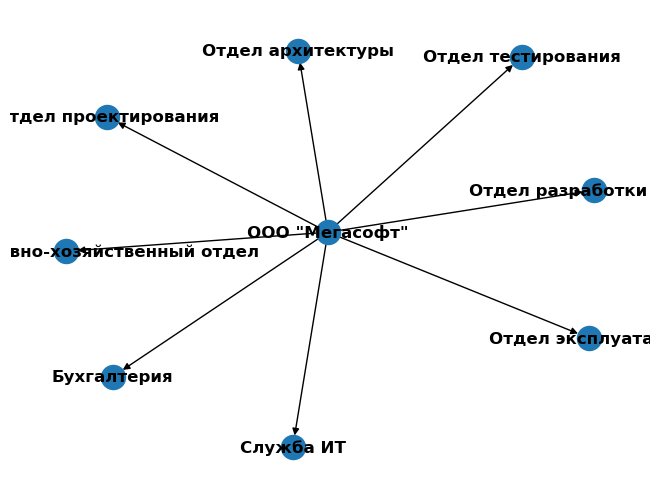

In [5]:
DG = nx.DiGraph()

DG.add_edge('ООО "Мегасофт"', departments_Unique_list[0]) 
DG.add_edge('ООО "Мегасофт"', departments_Unique_list[1]) 
DG.add_edge('ООО "Мегасофт"', departments_Unique_list[2]) 
DG.add_edge('ООО "Мегасофт"', departments_Unique_list[3]) 
DG.add_edge('ООО "Мегасофт"', departments_Unique_list[4]) 
DG.add_edge('ООО "Мегасофт"', departments_Unique_list[5]) 
DG.add_edge('ООО "Мегасофт"', departments_Unique_list[6]) 
DG.add_edge('ООО "Мегасофт"', departments_Unique_list[7]) 

nx.draw(DG, with_labels=True, font_weight='bold')